In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ReadingDataSets as rd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
import sklearn.metrics as skmetrics

In [2]:
#Get dataframe
data = rd.read_car_insurance_cold_calls()


In [17]:
#Check Documentation
#rd.read_car_insurance_cold_calls.__doc__

'\n    \n\n    Returns - A DataFrame Object - \n    Includes Independent Variables - Id, Age, Job, Marital, Education, Default,\n    Balance, HHInsurance, CarLoan, Communication, LastContactDay,\n    LastContactMonth, NoOfContacts, DaysPassed, PrevAttempts, Outcome,\n    CallStart, CallEnd\n    \n    Includes Dependent Variables - CarInsurance \n    -------\n    TYPE\n        DESCRIPTION - Reads in all Data from car_insurance_cold_calls.csv\n        Could do feature selection/feature engineering here and pass into IPNB\n\n    '

In [4]:
#Check form of the Data
#type(data)
data.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [5]:
#Encode the data
#Encode Job, Marital, Education, Communication
dataEncoded = pd.get_dummies(data,columns = ['Job'], drop_first=True)

dataEncoded = pd.get_dummies(dataEncoded,columns = ['Marital'], drop_first=True)

dataEncoded = pd.get_dummies(dataEncoded,columns = ['Education'], drop_first=True)

dataEncoded = pd.get_dummies(dataEncoded,columns = ['Communication'], drop_first=True)

dataEncoded = pd.get_dummies(dataEncoded,columns = ['Outcome'], drop_first=True)
#Alternative is to used Label Encoder then One Hot Encoding - but this is quicker

In [6]:
dataEncoded.columns

Index(['Id', 'Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan',
       'LastContactDay', 'LastContactMonth', 'NoOfContacts', 'DaysPassed',
       'PrevAttempts', 'CallStart', 'CallEnd', 'CarInsurance',
       'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Job_unemployed', 'Marital_married',
       'Marital_single', 'Education_secondary', 'Education_tertiary',
       'Communication_telephone', 'Outcome_other', 'Outcome_success'],
      dtype='object')

In [7]:
#Feature Engineering
#Assumptions made - time of the day not important for determining whether or not 
dataEncoded['CallEnd']=pd.to_datetime(dataEncoded['CallEnd'])
dataEncoded['CallStart']=pd.to_datetime(dataEncoded['CallStart'])
dataEncoded['CallDuration'] = dataEncoded['CallEnd'] - dataEncoded['CallStart']

In [8]:
#convert call duration into seconds
valuesToAddToDF = []
for calldurationstamp in dataEncoded['CallDuration']:
    
    formattedCallDurationStamp = (str(calldurationstamp).split(' ')[2])
    ftr = [3600,60,1]
    valueToAdd = sum([a*b for a,b in zip(ftr, map(int,formattedCallDurationStamp.split(':')))])
    valuesToAddToDF.append(valueToAdd)

#Create column called CallDurationSeconds - to include in matrix of features - remove CallEnd, CallStart and CallDuration
dataEncoded['CallDurationSeconds'] = valuesToAddToDF

In [9]:
#tells you the # of 0's and 1's
data['CarInsurance'].value_counts()

0    2396
1    1604
Name: CarInsurance, dtype: int64

In [10]:
'''i=1
for eachColumn in data.columns[1:-1]:
    plt.figure(figsize=(14, 35))
    plt.subplot(10, 2, i)
    i += 1
    sns.countplot(eachColumn, hue='CarInsurance', data=data)
    plt.show()'''

"i=1\nfor eachColumn in data.columns[1:-1]:\n    plt.figure(figsize=(14, 35))\n    plt.subplot(10, 2, i)\n    i += 1\n    sns.countplot(eachColumn, hue='CarInsurance', data=data)\n    plt.show()"

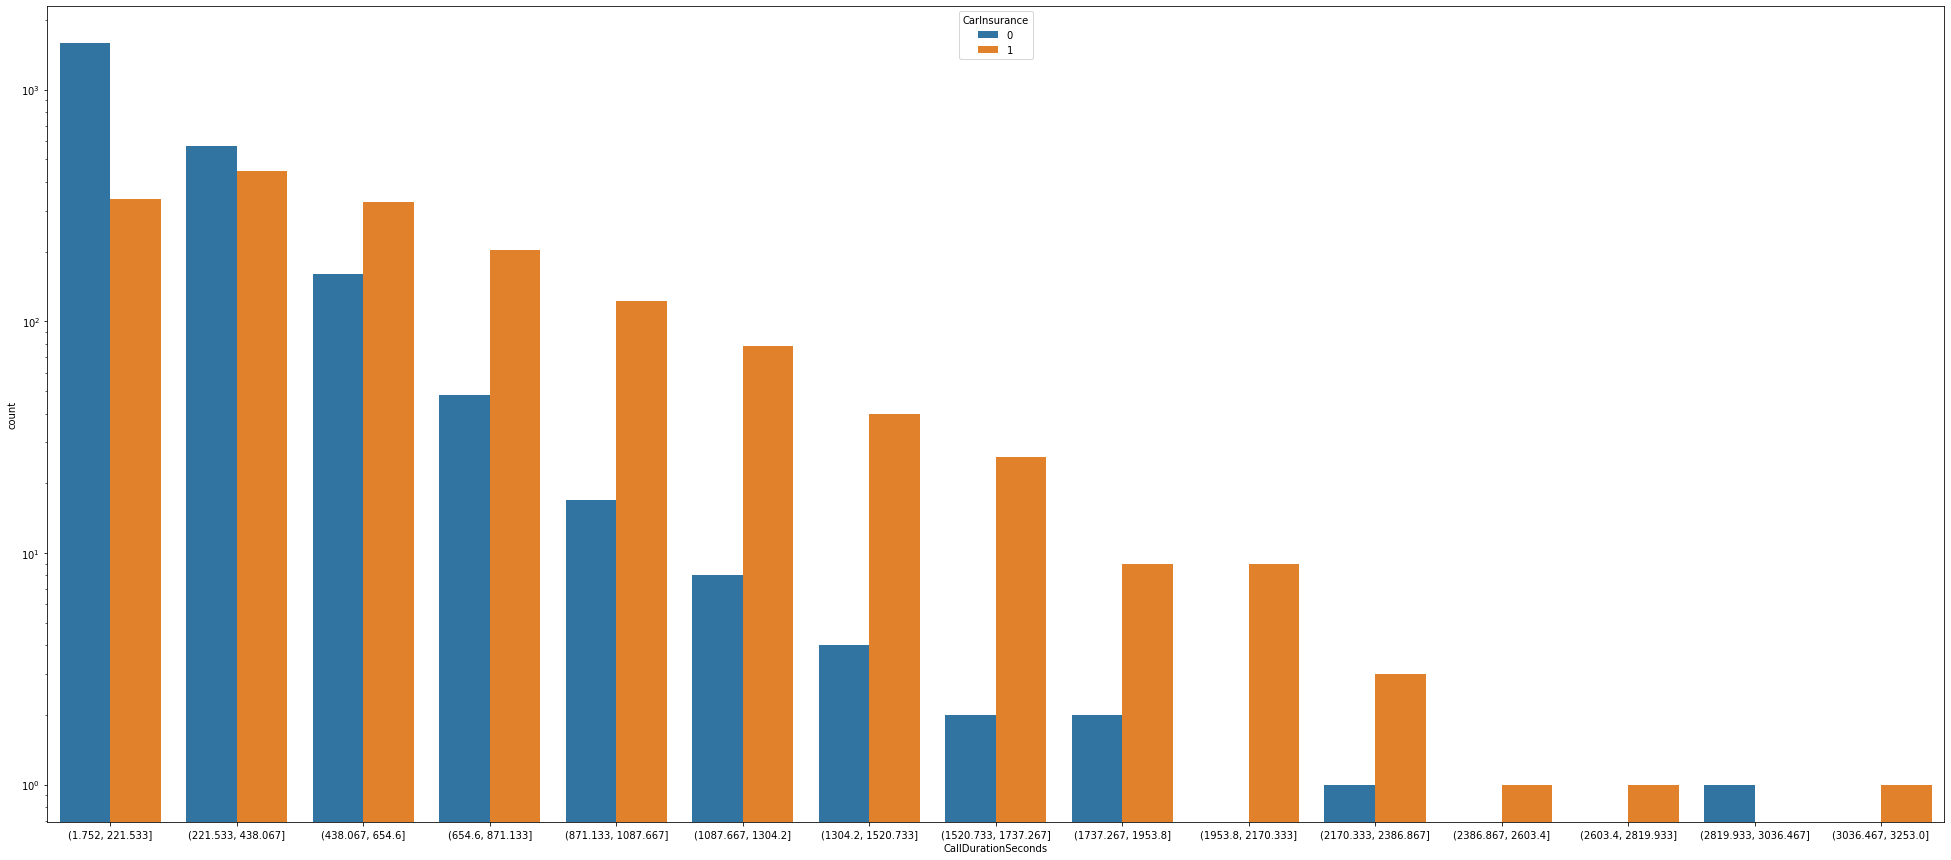

In [11]:
dataEncoded.sort_values("CallDurationSeconds", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')

valuesToAddToDF.sort()

callDurationBins=pd.cut(dataEncoded['CallDurationSeconds'],15)
#print(callDurationBins)
plt.figure(figsize=(34,15))
sns.countplot(callDurationBins, hue='CarInsurance', data=dataEncoded)
plt.yscale('log')

In [12]:
##add independent and dependent variables to x and y respectively 
#drop id, LastContactDay, LastContactMonth, CallStart, CallEnd
x=dataEncoded[['Age', 'Balance', 'HHInsurance', 'CarLoan',
        'NoOfContacts', 'DaysPassed',
       'PrevAttempts', 'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Job_unemployed',
       'Communication_telephone', 'Outcome_other', 'Outcome_success', 'CallDurationSeconds', 
       'Marital_married', 'Marital_single', 'Education_secondary', 'Education_tertiary']]

y=dataEncoded['CarInsurance']

In [13]:
#Create regressor objects
#should create multiple regressors for each algorithm and compare the results
lr = LogisticRegression(solver='lbfgs', max_iter=10000)
dtr5 = DecisionTreeClassifier(max_depth=5)
dtr10 = DecisionTreeClassifier(max_depth=10)
dtr15=DecisionTreeClassifier(max_depth=15)
rfr5 = RandomForestClassifier(max_depth=5, n_jobs = -1, n_estimators=2000)
rfr10 = RandomForestClassifier(max_depth=10, n_jobs = -1, n_estimators=2000)
rfr15 = RandomForestClassifier(max_depth=15, n_jobs = -1, n_estimators=2000)
rfr20 = RandomForestClassifier(max_depth=20, n_jobs = -1, n_estimators=2000)
rfr100 = RandomForestClassifier(max_depth=100, n_jobs = -1, n_estimators=2000)
gb5 = GradientBoostingClassifier(max_depth=5, n_estimators=2000)
gb10 = GradientBoostingClassifier(max_depth=10, n_estimators=2000)
gb15 = GradientBoostingClassifier(max_depth=15, n_estimators=2000)

In [14]:
#Add regressor objects into a dictionary
regressor_dictionary = {'Logistic Regression':lr,
                        'Decision Tree depth 5':dtr5,
                        'Decision Tree depth 10': dtr10,
                        'Decision Tree depth 15': dtr15,
                        'Random Forest depth 5':rfr5,
                        'Random Forest depth 10':rfr10,
                        'Random Forest depth 15':rfr15,
                        'Random Forest depth 20':rfr20,
                        'Random Forest depth 100':rfr100,
                        "Gradient Boosting depth 5": gb5,
                        "Gradient Boosting depth 10":gb10,
                        "Gradient Boosting depth 15":gb15,
                       }

In [16]:
kf = KFold(n_splits = 6, shuffle=True)

for key, regressor in regressor_dictionary.items():
    listOfAccuracyScore = []
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    #cross validation for each algorithm
    for train_idx, test_idx in kf.split(x, y):
        x_train, y_train, x_test, y_test = x.iloc[train_idx], y.iloc[train_idx], \
        x.iloc[test_idx], y.iloc[test_idx]
    
        regressor.fit(x_train, y_train)
        y_predicted = regressor.predict(x_test)
        #could use to deteremine other more meaningful metrics
        accuracy = (skmetrics.accuracy_score(y_test, y_predicted) * 100)
        listOfAccuracyScore.append(accuracy)
        
        #################################################################################
        #Uncomment for Individual confusion matrices
        #print("===============================================================")
        #print("CONFUSION MATRIX for " + str(regressor) + " ==== \n" + str(skmetrics.confusion_matrix(y_test, y_predicted)))
        #print('Our model has correctly classified {0}% of all observations in the test data' \
                  #.format(skmetrics.accuracy_score(y_test, y_predicted) * 100))
        #print("===============================================================")
        #################################################################################
    average_accuracy_score = (sum(listOfAccuracyScore) / len(listOfAccuracyScore))
    print("For " + key + " the average score is " + str(average_accuracy_score))
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Logistic Regression the average score is 80.65006535771153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Decision Tree depth 5 the average score is 79.10065237651445
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Decision Tree depth 10 the average score is 78.79982681332007
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Decision Tree depth 15 the average score is 75.12418715567142
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Random Forest depth 5 the average 